# Jury prediction from separate keras networks

In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import subprocess

Load in hmm predictions, pssm predcitions and dssp information

> Objects have been pickled using Python 3.6

In [4]:
i=1
exp='20Sep_2'

In [5]:
home='/cluster/gjb_lab/2472402'
hmmfile=os.path.join(home,'outputs/keras_train_CV/HMM/26Aug/cross-val%d/results.pkl'%i)
pssmafile=os.path.join(home,'outputs/keras_train_CV/PSSM/26Aug/cross-val%d/results.pkl'%i)
pssmbfile=os.path.join(home,'outputs/keras_train_CV/PSSMb/26Aug/cross-val%d/results.pkl'%i)

with open(hmmfile,'rb') as fh:
    (_,(seqIDs,Y,_,hmmpred)) = pickle.load(fh)
    assert seqIDs
    assert Y
    assert hmmpred
    
with open(pssmafile,'rb') as fp:
    (_,(seqIDs2,Y2,_,pssmapred)) = pickle.load(fp)
    assert seqIDs2==seqIDs
    assert Y2
    assert pssmapred
    
with open(pssmbfile,'rb') as fb:
    (_,(seqIDs3,Y3,_,pssmbpred)) = pickle.load(fb)
    assert seqIDs3==seqIDs
    assert Y3
    assert pssmbpred    

# function to test equality in list of np.ndarray
is_equal = lambda arg1,arg2: all([np.array_equal(arg11,arg12) for arg11,arg12 in zip(arg1,arg2)])
assert is_equal(Y,Y2) 
assert is_equal(Y,Y3) 

In [12]:
j=1 # test domain by domain
seqID=seqIDs[j]
hmm=hmmpred[j]
pssma=pssmapred[j]
pssmb=pssmbpred[j]
dssp=Y[j]

In [66]:
# iterate over all residues, 
# calculate average of PSSMa and PSSMb
# if there is a disagreement, take mathematical average of the array, calculate confidence from this average
# if there is no disagreement, use pssm results, calculate condifgence from pssm
# convert triplets to letters

In [13]:
pssm=pssma/2+pssmb/2
plet=np.asarray([np.argmax(p) for p in pssm])
hlet=np.asarray([np.argmax(h) for h in hmm])

In [14]:
conf=[]
jpred=str()
is_disagree=plet!=hlet # get positions which differ
for pos, disagree in enumerate(is_disagree):
    if disagree: # pssm and hmm predictions differ
        # get the average
        final_vec=pssm[pos]/2+hmm[pos]/2 # vector of len 3
    else:
        # use the psi networks
        final_vec=pssm[pos]
    
    # create masked array
    final_vec=np.ma.array(final_vec,mask=False)

    # find the largest logit
    maxone=np.argmax(final_vec)
    
    # get second highest logit
    final_vec.mask[maxone]=True
    maxtwo=np.argmax(final_vec)
    
    # append to joint prediction
    
    jpred_let={0:'E',1:'H',2:'-'}[maxone]
    jpred+=jpred_let

    # append to confidence list
    conf.append(10*(final_vec.data[maxone]-final_vec.data[maxtwo]))

In [15]:
jpred

'---E---------------HHHHHHHHHHHH------HHHHHHHHHH------------EEEEEEEEEEE-----HHHHHHHHHH---------EEEEE--EE--------HHHHHHHHHHHHHHHHHHHH----EEE-----EEEEEEHHH-----EEEEE-------H-HHHHHHH----HHHHHHHH---HEE----EEEEEEE---------HHHHHHHHHHHH-----EEEEEEE------------HHH---HHHH---EEEE---HHHHHHHH------HHHHHHHH-----------E-EEEEEE---EEEEE--------EEEEEE------------EEEEEEE-------HHHHHHHHHHHHHHHH-------EEEEE---HHHHHHHHHHHHHHHHHHHHEEE----------------------EEEEE------E---------EEEEE-HHHHHHHHHHEE-----------------EEE--------HHH--------------------'

In [16]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=False, grid=False)

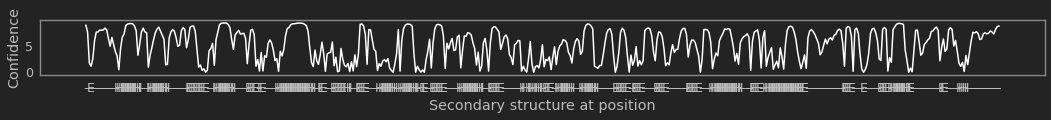

In [19]:
plt.figure(figsize=(18,1))
plt.plot(conf,'w')
plt.xticks(range(0,len(conf)),list(jpred))
plt.ylabel("Confidence")
plt.xlabel("Secondary structure at position")
plt.show()

In [22]:
exp = '20Sep_2'
irange = range(1,8)
# for each fold of cross validation
for i in irange:
    home='/cluster/gjb_lab/2472402'
    hmmfile=os.path.join(home,'outputs/keras_train_CV/HMM/%s/cross-val%d/results.pkl'%(exp,i))
    pssmafile=os.path.join(home,'outputs/keras_train_CV/PSSM/%s/cross-val%d/results.pkl'%(exp,i))
    pssmbfile=os.path.join(home,'outputs/keras_train_CV/PSSMb/%s/cross-val%d/results.pkl'%(exp,i))

    with open(hmmfile,'rb') as fh:
        (_,(seqIDs,Y,_,hmmpred)) = pickle.load(fh)
        assert seqIDs
        assert Y
        assert hmmpred

    with open(pssmafile,'rb') as fp:
        (_,(seqIDs2,Y2,_,pssmapred)) = pickle.load(fp)
        assert (((seqIDs[i]==seqIDs2[i]).all() for i in range(len(seqIDs))))
        assert Y2
        assert pssmapred

    with open(pssmbfile,'rb') as fb:
        (_,(seqIDs3,Y3,_,pssmbpred)) = pickle.load(fb)
        assert (((seqIDs[i]==seqIDs3[i]).all() for i in range(len(seqIDs))))
        assert Y3
        assert pssmbpred    

    # function to test equality in list of np.ndarray
    is_equal = lambda arg1,arg2: all([np.array_equal(arg11,arg12) for arg11,arg12 in zip(arg1,arg2)])
    assert is_equal(Y,Y2) 
    assert is_equal(Y,Y3) 
    
    conf_all=[]
    jpred_all=[]
    # for each domain in the cross-val
    for j in range(0,len(Y)):
        seqID=seqIDs[j]
        hmm=hmmpred[j]
        pssma=pssmapred[j]
        pssmb=pssmbpred[j]
        dssp=Y[j]
        pssm=pssma/2+pssmb/2
        plet=np.asarray([np.argmax(p) for p in pssm])
        hlet=np.asarray([np.argmax(h) for h in hmm])

        conf=[]
        jpred=str()
        is_disagree=plet!=hlet # get positions which differ
        # for each amino acid position in the domain
        for pos, disagree in enumerate(is_disagree):
            if disagree: # pssm and hmm predictions differ
                # get the average
                final_vec=pssm[pos]/2+hmm[pos]/2 # vector of len 3
            else:
                # use the psi networks
                final_vec=pssm[pos]

            # create masked array
            final_vec=np.ma.array(final_vec,mask=False)

            # find the largest logit
            maxone=np.argmax(final_vec)

            # get second highest logit
            final_vec.mask[maxone]=True
            maxtwo=np.argmax(final_vec)

            # append to joint prediction

            jpred_let={0:'E',1:'H',2:'-'}[maxone]
            jpred+=jpred_let

            # append to confidence list
            conf.append(10*(final_vec.data[maxone]-final_vec.data[maxtwo]))
        
        conf_all.append(conf)
        jpred_all.append(jpred)
        
        

In [23]:
len(conf_all)

190

# Integrate into sov-and-accuracy scoring

In [6]:
import pandas as pd
import numpy as np
import os
import pickle
import subprocess

Merge with code in keras section from my earlier notebook 'jupyter_notebooks/model_evalutation/2021-08-26-sov-and-accuracy.ipynb'

From above notebook:
modified function to score Q3 and SOV for hmm, pssm, and jpred.

It runs calSOV 3 times per domain

In [28]:
def calc(outfolder,seqID,seq,dssp,hmm_pred,pssm_pred,jpred): 
    n=len(seq)
    assert n!=0
    assert all(_==n for _ in [len(dssp),len(hmm_pred),len(pssm_pred)])
    jpred=jpred.replace('-','C')
    hmm_pred=hmm_pred.replace('-','C')
    pssm_pred=pssm_pred.replace('-','C')
    dssp=dssp.replace('-','C')
    # write three sov.in file
    hmm_sov_in=os.path.join(outfolder,'%s.hmm.sov.in' % seqID)
    pssm_sov_in=os.path.join(outfolder,'%s.pssm.sov.in' % seqID)
    jpred_sov_in=os.path.join(outfolder,'%s.jpred.sov.in' % seqID)
    
    with open(hmm_sov_in,'w+') as f_hmm, open(pssm_sov_in,'w+') as f_pssm, open(jpred_sov_in,'w+') as f_jpred:
        f_hmm.write("AA  OSEC PSEC\n")
        f_pssm.write("AA  OSEC PSEC\n")
        f_jpred.write("AA  OSEC PSEC\n")
        for (aa,osec,psec_hmm,psec_pssm,psec_jpred) in zip(seq,dssp,hmm_pred,pssm_pred,jpred): # no commas allowed
            f_hmm.write("%s   %s    %s\n" % (aa,osec,psec_hmm))
            f_pssm.write("%s   %s    %s\n" % (aa,osec,psec_pssm))
            f_jpred.write("%s   %s    %s\n" % (aa,osec,psec_jpred))
    
    hmm_sov_out=os.path.join(outfolder,'%s.hmm.sov.out' % seqID)
    pssm_sov_out=os.path.join(outfolder,'%s.pssm.sov.out' % seqID)
    jpred_sov_out=os.path.join(outfolder,'%s.jpred.sov.out' % seqID)
    
    # need to change binpath
    sov_binpath = '/cluster/gjb_lab/2472402/scripts/calSOV'
    cmd_hmm="%s -f 1 %s -o %s" % (sov_binpath,hmm_sov_in,hmm_sov_out) # must have calSOV installed and path configured
    cmd_pssm="%s -f 1 %s -o %s" % (sov_binpath,pssm_sov_in,pssm_sov_out)
    cmd_jpred="%s -f 1 %s -o %s" % (sov_binpath,jpred_sov_in,jpred_sov_out)
    proc_hmm=subprocess.run(args=cmd_hmm.split())
    proc_pssm=subprocess.run(args=cmd_pssm.split())
    proc_jpred=subprocess.run(args=cmd_jpred.split())

    assert proc_hmm.returncode==0
    assert proc_pssm.returncode==0
    assert proc_jpred.returncode==0
    assert os.path.exists(hmm_sov_out)
    assert os.path.exists(pssm_sov_out)
    assert os.path.exists(jpred_sov_out)

    with open(hmm_sov_out,'r') as f:
        lines=f.read().splitlines()
        ans=lines[1].split()
        hmm_sov,hmm_acc=ans[1],ans[10]
            
    with open(pssm_sov_out,'r') as f:
        lines=f.read().splitlines()
        ans=lines[1].split()
        pssm_sov,pssm_acc=ans[1],ans[10]
    
    with open(jpred_sov_out,'r') as f:
        lines=f.read().splitlines()
        ans=lines[1].split()
        jpred_sov,jpred_acc=ans[1],ans[10]

    assert(_!="nan" & _!="-nan" for _ in [hmm_sov,hmm_acc,pssm_sov,pssm_acc,jpred_sov,jpred_acc])    
        
    return tuple([float(v) for v in (hmm_acc,pssm_acc,jpred_acc,hmm_sov,pssm_sov,jpred_sov)])

Main code

In [8]:
irange = range(1,8)
expt_name='20Sep_2'
out_name='20Sep_2'

In [31]:
# for each fold of cross validation
for i in irange:
    home='/cluster/gjb_lab/2472402'
    hmmfile=os.path.join(home,'outputs/keras_train_CV/HMM/%s/cross-val%d/results.pkl'%(expt_name,i))
    pssmafile=os.path.join(home,'outputs/keras_train_CV/PSSM/%s/cross-val%d/results.pkl'%(expt_name,i))
    pssmbfile=os.path.join(home,'outputs/keras_train_CV/PSSMb/%s/cross-val%d/results.pkl'%(expt_name,i))
    fastadir='/homes/adrozdetskiy/Projects/jpredJnet231ReTrainingSummaryTable/scores/training'
    sov_folder=os.path.join(home,'sov/keras/%s/cross-val%d'%(out_name,i)) # output folder for sov results
    if not os.path.exists(sov_folder):
        os.system("mkdir %s" % sov_folder)

    with open(hmmfile,'rb') as fh:
        (_,(seqIDs,Y,_,hmmpred)) = pickle.load(fh)
        assert seqIDs
        assert Y
        assert hmmpred

    with open(pssmafile,'rb') as fp:
        (_,(seqIDs2,Y2,_,pssmapred)) = pickle.load(fp)
        assert (((seqIDs[i]==seqIDs2[i]).all() for i in range(len(seqIDs))))
        assert Y2
        assert pssmapred

    with open(pssmbfile,'rb') as fb:
        (_,(seqIDs3,Y3,_,pssmbpred)) = pickle.load(fb)
        assert (((seqIDs[i]==seqIDs3[i]).all() for i in range(len(seqIDs))))
        assert Y3
        assert pssmbpred    

    # function to test equality in list of np.ndarray
    is_equal = lambda arg1,arg2: all([np.array_equal(arg11,arg12) for arg11,arg12 in zip(arg1,arg2)])
    assert is_equal(Y,Y2) 
    assert is_equal(Y,Y3) 
        
    # in some cross-validation files, there is a bug and seqIDs is a list of series
    # test for that and reduce seqIDs if necessary
    if isinstance(seqIDs[0],pd.Series):
        seqIDs = [seqID[0] for seqID in seqIDs]
    
    assert all([isinstance(seqID,str) for seqID in seqIDs])
    
    # declare a bunch of accumulators
    # in the following lists, each list element is one domain
    hmm_acc_all=[]
    pssm_acc_all=[]
    jpred_acc_all=[]
    hmm_sov_all=[]
    pssm_sov_all=[]
    jpred_sov_all=[]
    hmm_pred_all=[]
    pssm_pred_all=[]
    jpred_all=[]
    jury_all=[]
    conf_all=[]
    seqs_all=[]
    dssp_all=[]
    
    # for each domain in the cross-val
    for j in range(0,len(Y)): # use index instead of zipping as I previously did
        seqID=seqIDs[j]
        hmm=hmmpred[j]
        pssma=pssmapred[j]
        pssmb=pssmbpred[j]
        dssp = Y[j].to_numpy()
        pssm=pssma/2+pssmb/2
        plet=np.asarray([np.argmax(p) for p in pssm]) # FYI: 'let' stands for letter
        hlet=np.asarray([np.argmax(h) for h in hmm])
        dlet=np.asarray([np.argmax(d) for d in dssp]) # dssp letter => dlet
        
        # obtain string version of dssp and hmm,pssm predictions
        dssp_str=''.join(str(_) for _ in list(dlet))
        hmm_pred=''.join(str(_) for _ in list(hlet))
        pssm_pred=''.join(str(_) for _ in list(plet))
        # convert argmax indices to 3 chars
        for s,t in {'0':'E','1':'H','2':'-'}.items(): 
            dssp_str=dssp_str.replace(s,t)
            hmm_pred=hmm_pred.replace(s,t)
            pssm_pred=pssm_pred.replace(s,t)
            
        dssp_all.append(dssp_str)
        hmm_pred_all.append(hmm_pred)
        pssm_pred_all.append(pssm_pred)
        
        fasta_file=os.path.join(fastadir,'%s.fasta' % seqID)
        assert os.path.exists(fasta_file)
        with open(fasta_file,'r') as f:
            seq=f.read().splitlines()[1]
        
        seqs_all.append(seq)
        
        # obtain string predictions and confidence scores for jnet
        
        # each element/char in the lists/strings below represents one amino acid (aa) position
        conf=[] 
        jpred=str() 
        jury=str() 
        is_disagree=plet!=hlet  # bool array of where hmm and pssm nets disagree
        
        # for each aa position in the domain
        for pos, disagree in enumerate(is_disagree):
            if disagree: # pssm and hmm predictions differ
                final_vec=pssm[pos]/2+hmm[pos]/2 # vector of len 3
                jury+='*'
            else:
                # use the psi networks
                final_vec=pssm[pos]
                jury+=' '

            # create masked array
            final_vec=np.ma.array(final_vec,mask=False)

            # find the largest logit
            maxone=np.argmax(final_vec)

            # get second highest logit
            final_vec.mask[maxone]=True
            maxtwo=np.argmax(final_vec)

            # append to joint prediction

            jpred_let={0:'E',1:'H',2:'-'}[maxone]
            jpred+=jpred_let

            # append to confidence list
            conf.append(10*(final_vec.data[maxone]-final_vec.data[maxtwo]))
            
            assert conf
            assert jpred
            assert jury
        
        # go back to domain level
        # obtain accuracy values and SOV scores for jpred, hmm, and pssm
        (hmm_acc,pssm_acc,jpred_acc,hmm_sov,pssm_sov,jpred_sov)=calc(sov_folder,seqID,seq,dssp_str,hmm_pred,pssm_pred,jpred)
        
        # each list element is one domain
        jpred_acc_all.append(jpred_acc)
        hmm_acc_all.append(hmm_acc)
        pssm_acc_all.append(pssm_acc)
        jpred_sov_all.append(jpred_sov)
        pssm_sov_all.append(pssm_sov)
        hmm_sov_all.append(hmm_sov)
        conf_all.append(conf)
        jpred_all.append(jpred)
        jury_all.append(jury)
    
    # zip together the various information of all domains
    results=zip(seqIDs,jpred_acc_all,hmm_acc_all,pssm_acc_all,jpred_sov_all,hmm_sov_all,pssm_sov_all)
    alignments=zip(seqIDs,seqs_all,dssp_all,jpred_all,hmm_pred_all,pssm_pred_all,conf_all,jury_all)
    
    # output results to csv file 
    # choice to do this once per CV fold instead of once per domain
    # so as to avoid opening and closing of file as many times as there are domains in that CV fold
    # a consequence is we have to accumulate the results into the *_all lists above
    
    out_folder='/cluster/gjb_lab/2472402/results/keras/%s' % out_name
    if not os.path.exists(out_folder):
        os.system("mkdir %s" % out_folder)
    out_csv='cv%i_scores.csv' % i
    with open(os.path.join(out_folder,out_csv),'w+') as f:
        f.write("seqID,JNET_acc,HMM_acc,PSSM_acc,JNET_sov,HMM_sov,PSSM_sov\n")
        for (seqID,jpred_acc,hmm_acc,pssm_acc,jpred_sov,hmm_sov,pssm_sov) in results:
            line="%s,%.2f,%.2f,%.2f,%.2f,%.2f,%.2f\n" % (seqID,jpred_acc,hmm_acc,pssm_acc,jpred_sov,hmm_sov,pssm_sov)
            f.write(line)

    # write alignments to kerasnet file
    out_knet='cv%i.knet' % i
    with open(os.path.join(out_folder,out_knet),'w+') as f:
        for (seqID,seq,dssp,jpred,hmm_pred,pssm_pred,conf,jury) in alignments:
            f.write("seqID     : %s\n" % seqID)
            f.write("sequence  : %s\n" % seq)
            f.write("DSSP      : %s\n" % dssp)
            f.write("JNET_pred : %s\n" % jpred)
            f.write("JNET_conf : %s\n" % ''.join(str("%d" % _) for _ in conf))
            f.write("HMM_pred  : %s\n" % hmm_pred)
            f.write("PSSM_pred : %s\n" % pssm_pred)
            f.write("JNET_jury : %s\n" % jury)
            